# やりたいこと

* あるデータでモデルを構築したとき、テストデータのハズレを確認して理由を知りたい

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# データの読み込み

In [6]:
d = load_iris()

In [7]:
d.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [13]:
x = pd.DataFrame(d['data'], columns=d['feature_names'])
y = pd.DataFrame(d['target'], columns=['y_target'])

In [15]:
df = pd.concat([x, y], axis=1)

In [18]:
df.loc[:, 'target'] = df['y_target'].map({idx:t for idx, t in enumerate(d['target_names'])})

In [19]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_target,target
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [23]:
df = pd.concat([df, pd.get_dummies(df['y_target'], prefix='y_target')], axis=1)

In [24]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_target,target,y_target_0,y_target_1,y_target_2
0,5.1,3.5,1.4,0.2,0,setosa,1,0,0
1,4.9,3.0,1.4,0.2,0,setosa,1,0,0
2,4.7,3.2,1.3,0.2,0,setosa,1,0,0
3,4.6,3.1,1.5,0.2,0,setosa,1,0,0
4,5.0,3.6,1.4,0.2,0,setosa,1,0,0


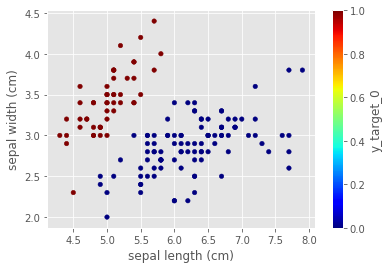

In [29]:
_, ax = plt.subplots()
df.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c='y_target_0', cmap='jet', ax=ax)
plt.show()

線形だったら１つ間違えるかなって予想

# モデル構築

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df[['sepal length (cm)', 'sepal width (cm)']],
                                                    df['y_target_0'], test_size=0.3, random_state=71)

In [34]:
rf = RandomForestClassifier(n_estimators=100,  min_samples_split=2, min_samples_leaf=2, max_depth=3, random_state=71)

In [36]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=71, verbose=0, warm_start=False)

In [38]:
print(classification_report(y_train, rf.predict(X_train)))
print(classification_report(y_test, rf.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        69
          1       1.00      1.00      1.00        36

avg / total       1.00      1.00      1.00       105

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        31
          1       1.00      1.00      1.00        14

avg / total       1.00      1.00      1.00        45



なるほど...

## learning curveを確認する

In [40]:
from sklearn.learning_curve import learning_curve

In [41]:
rf = RandomForestClassifier(n_estimators=100,  min_samples_split=2, min_samples_leaf=2, max_depth=3, random_state=71)

In [43]:
train_sizes, train_scores, valid_scores = learning_curve(rf, df[['sepal length (cm)', 'sepal width (cm)']],
                                                         df['y_target_0'], train_sizes=[30, 40, 50, 60, 70, 80, 90, 100], cv=5)

In [97]:
take_means = lambda s: np.mean(s, axis=1)

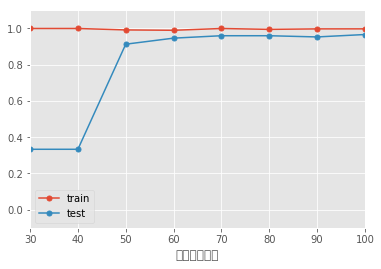

In [100]:
_, ax = plt.subplots()
ax.plot(take_means(train_scores), marker='.', markersize=10, label='train')
ax.plot(take_means(valid_scores), marker='.', markersize=10, label='test')
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(0, len(train_sizes) - 1)
ax.set_xlabel('訓練データ数')
ax.set_xticklabels(train_sizes.tolist())

plt.legend()
plt.show()

In [160]:
X_train, X_test, y_train, y_test = train_test_split(df[['sepal length (cm)', 'sepal width (cm)']],
                                                    df['y_target_0'], train_size=0.3, random_state=71)
rf = RandomForestClassifier(n_estimators=100,  min_samples_split=2, min_samples_leaf=2, max_depth=3, random_state=71)
rf.fit(X_train, y_train)
print(classification_report(y_train, rf.predict(X_train)))
print(classification_report(y_test, rf.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        24
          1       1.00      1.00      1.00        21

avg / total       1.00      1.00      1.00        45

             precision    recall  f1-score   support

          0       1.00      0.91      0.95        76
          1       0.81      1.00      0.89        29

avg / total       0.95      0.93      0.94       105



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


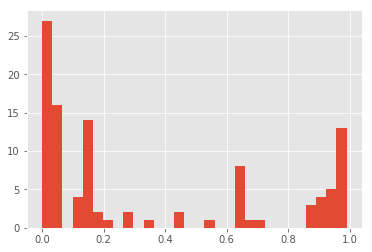

In [161]:
plt.hist(np.array(rf.predict_proba(X_test))[:, 1], bins=30)
plt.show()

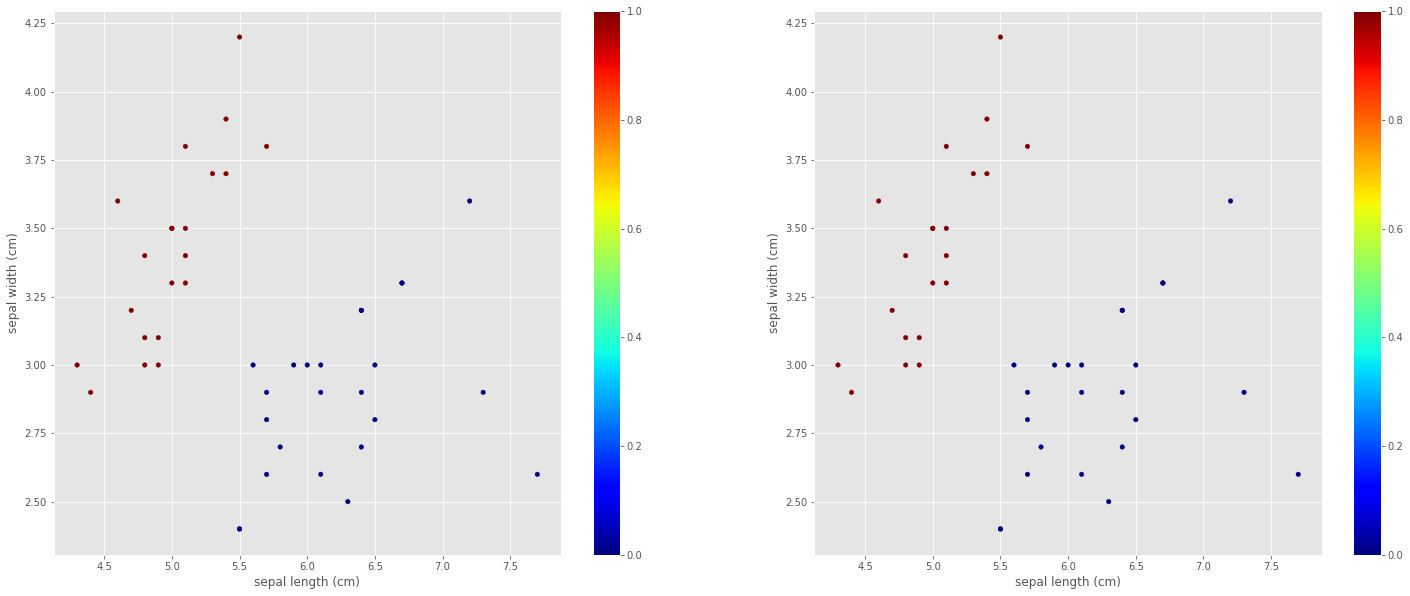

In [174]:
_, axes = plt.subplots(ncols=2, figsize=(25, 10))
X_train.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c=y_train, cmap='jet', ax=axes[0])
X_train.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c=rf.predict(X_train), cmap='jet', ax=axes[1])
plt.show()

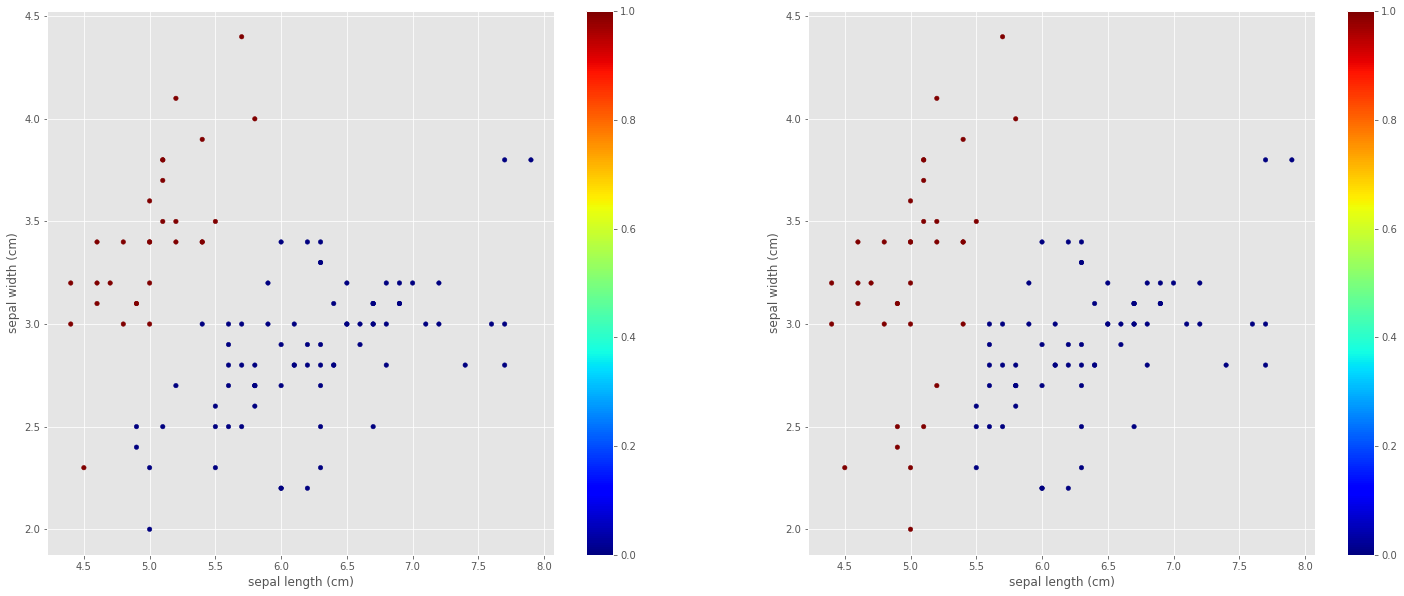

In [173]:
_, axes = plt.subplots(ncols=2, figsize=(25, 10))
X_test.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c=y_test, cmap='jet', ax=axes[0])
X_test.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c=rf.predict(X_test), cmap='jet', ax=axes[1])
plt.show()

* これは未学習になるのかな？ -> (2.5, 5.0)あたりを学習しきれていないと思われる
* 複雑なものになると散布図で確認できないと思うけどどうすればいいんや・・・
* mnistとか画像データは散布図ではわからんし、結局データみないと駄目だし

外したには色々理由があるから、それを並べて１つずつ確認していけばいいんかな

* learning curveを確認
    * https://chezou.hatenablog.com/entry/2016/05/29/215739
    * 未学習 -> high bias -> 学習データが少ない、学習データで分布を捉えきれなかった -> 学習・テストデータともに精度が低い
    * 過学習 -> high variance -> 学習データに対しては精度が高いが、テストデータに対しては精度が低い
* 決定境界の確認
    * 上記irisの場合はわかりやすく、線形でも分離できそうな雰囲気
    * 決定境界が曖昧、また分布がごちゃごちゃしている場合は新しい特徴量の追加が必要になると考える
* モデルの確率値の確認
    * 正解のデータに対し、予測値が高いなら良い
    * 不正解のデータで予測値が高いのはおかしい -> 間違えて学習している可能性
    * 正解のデータでも予測値が小さい場合はランダムに近いため、学習しきれていない判断で良い？
* AUCの値の確認
    * モデルの良し悪しが判断できる？

とりあえずこれらを確認できるようにしましょう.